In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# read_data and make train and test data for example
# https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023
def read_data():
    df = pd.read_csv("ds_salaries.csv")
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
    return df_train.reset_index(drop=True), df_test.reset_index(drop=True)

df_train, df_test = read_data()
print(df_train.shape, df_test.shape)
df_train

(3004, 11) (751, 11)


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2022,SE,FT,Data Engineer,35000,EUR,36773,ES,0,ES,M
1,2023,MI,FT,Research Scientist,151800,USD,151800,US,100,US,M
2,2022,SE,FT,Data Analyst,100000,USD,100000,US,0,US,M
3,2022,SE,FT,Data Engineer,156600,USD,156600,US,100,US,M
4,2023,SE,FT,Data Engineer,175000,USD,175000,US,100,US,M
...,...,...,...,...,...,...,...,...,...,...,...
2999,2023,SE,FT,Machine Learning Engineer,150000,USD,150000,US,100,US,M
3000,2023,SE,FT,Data Analyst,180180,USD,180180,US,0,US,M
3001,2023,EX,FT,Data Engineer,310000,USD,310000,US,100,US,M
3002,2021,MI,FT,Research Scientist,53000,EUR,62649,FR,50,FR,M


In [2]:
# make baseblock for funciton. Update by class inheritance.
class Base():
    def fit(self, input_df: pd.DataFrame):
        return self.transform(input_df)
    def transform(self, input_df: pd.DataFrame)->pd.DataFrame:
        raise NotImplementedError()

In [3]:
## 要修正
# # 時間特徴量の簡易処理（あれば。事前に時間特徴量にparse_datesで変換しておく。）
# # 時間を分解
# def sep_time(df, col, col2=0):
#   df[col+"_y"]=df[col].dt.year
#   df[col+"_m"]=df[col].dt.month
#   df[col+"_d"]=df[col].dt.day
#   if col2!=0:
#     df[col2+"_y"]=df[col2].dt.year
#     df[col2+"_m"]=df[col2].dt.month
#     df[col2+"_d"]=df[col2].dt.day
#     df[col+"-"+col2]=df[col] - df[col2]
#   return df

# def time_encode(df, col):
#     # この方法だと場合によって最大値が変化するデータでは正確な値は出ない
#     # 例：月の日数が30日や31日の場合がある
#     df[col + '_cos'] = np.cos(2 * np.pi * df[col] / df[col].max())
#     df[col + '_sin'] = np.sin(2 * np.pi * df[col] / df[col].max())
#     return df


In [4]:
# 数値カラムの外れ値の影響を減らすためのクリッピング
class ClipNumeric(Base):
  def __init__(self,col):
    # 数値コラムでなければエラーを出す
    if df_train[col].dtype == "float64" or df_train[col].dtype == "int64":
      self.col = col 
    else:
      raise ValueError("col is not numeric")
    
  def transform(self, input_df):
    out_df = pd.DataFrame()
    upperbound, lowerbound= np.percentile(input_df[self.col],[1,99])
    out_df[self.col]=np.clip(input_df[self.col],upperbound,lowerbound)
    assert len(out_df)==len(input_df)
    return out_df.add_suffix("_clip")

test = ClipNumeric("work_year")
test.transform(df_train)

,work_year_clip
0,2022
1,2023
2,2022
3,2022
4,2023
...,...
2999,2023
3000,2023
3001,2023
3002,2021


54


<AxesSubplot:title={'center':'job_title'}>

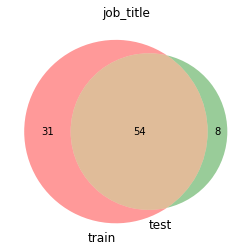

In [5]:
#カテゴリ列について、trainingにしか現れないカテゴリ、もしくはtestにしか現れないカテゴリを可視化
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

def check_cat(df_train, df_test, col):
  train_s = set(df_train[col].unique())
  test_s = set(df_test[col].unique())
  fig, ax = plt.subplots(figsize=(6, 4))
  venn2(subsets=(train_s, test_s), set_labels=('train', 'test'),ax=ax)
  ax.set_title(col)
  common = train_s & test_s
  print(len(common))
  # print(common)
  return ax

check_cat(df_train, df_test, "job_title")

In [6]:
#カテゴリ特徴量について、トレーニングに一定数以上いない物をまとめてOthersに落とす。
class DropMinorCatToOthers(Base):
  def __init__(self,col):
    self.col = col
    self.thresh = 10
    
  def fit(self, input_df):
    output_df = pd.DataFrame()
    value_count = input_df[self.col].value_counts()
    apply_values = value_count[value_count < self.thresh].index
    output_df[self.col] = input_df[self.col].where(~(input_df[self.col].isin(apply_values)),"Others")
    self.apply_values_ = apply_values
    return output_df
  
  def transform(self, input_df):
    output_df = pd.DataFrame()
    output_df[self.col] = input_df[self.col].where(~(input_df[self.col].isin(self.apply_values_)),"Others")
    return output_df

test = DropMinorCatToOthers("job_title")
test.fit(df_train)

,job_title
0,Data Engineer
1,Research Scientist
2,Data Analyst
3,Data Engineer
4,Data Engineer
...,...
2999,Machine Learning Engineer
3000,Data Analyst
3001,Data Engineer
3002,Research Scientist


In [7]:
# 主にコンペ用。One_hot_encodingではトレーニングデータとテストデータに共通しない値をOthersに落とす。周辺の特徴量を用いて汎用的な値に直すことも検討
class DropOnlyTrainTestValuesToOthers(Base):
  def __init__(self, col):
    self.col = col
  
  def transform(self, input_df):
    output_df = pd.DataFrame()
    train_values = set(df_train[self.col].unique())
    test_values = set(df_test[self.col].unique())
    common_values = train_values & test_values
    output_df[self.col] = input_df[self.col].where(input_df[self.col].isin(common_values),"Others")
    return output_df
  
test = DropOnlyTrainTestValuesToOthers("job_title")
test.fit(df_train)

,job_title
0,Data Engineer
1,Research Scientist
2,Data Analyst
3,Data Engineer
4,Data Engineer
...,...
2999,Machine Learning Engineer
3000,Data Analyst
3001,Data Engineer
3002,Research Scientist


In [8]:
# カテゴリのone_hot_encoding用。コンペ用の変換。
# TrainとTestに共通に出現する値のみでone_hot_encodingを行う。
# 実務であればTrain側のカテゴリを保有して予測時に適用する形に編集する
class OneHotEncoding(Base):
    def __init__(self, col):
        self.col = col
        train_values = df_train[self.col].unique()
        test_values = df_test[self.col].unique()
        self.common_values = set(train_values) & set(test_values)
    
    def fit(self, input_df):
        drop_minor_values = DropMinorCatToOthers(self.col)
        dropped_minor_input_df = drop_minor_values.fit(input_df)
        choose_only_common_value = DropOnlyTrainTestValuesToOthers(self.col)
        common_input_df = choose_only_common_value.fit(dropped_minor_input_df)
        cat = pd.Categorical(common_input_df[self.col], categories=self.common_values)
        out_df = pd.get_dummies(cat)
        return out_df
    
    
    def transform(self, input_df):
        drop_minor_values = DropMinorCatToOthers(self.col)
        dropped_minor_input_df = drop_minor_values.transform(input_df)
        choose_only_common_value = DropOnlyTrainTestValuesToOthers(self.col)
        common_input_df = choose_only_common_value.transform(dropped_minor_input_df)
        cat = pd.Categorical(common_input_df[self.col], categories=self.common_values)
        out_df = pd.get_dummies(cat)
        return out_df
    


test = OneHotEncoding("job_title")
test.fit(df_train)

    

,Data Science Consultant,Product Data Analyst,AI Developer,Data Science Engineer,Data Infrastructure Engineer,3D Computer Vision Researcher,Head of Data Science,Machine Learning Scientist,Big Data Engineer,Data Science Manager,...,Head of Data,Data Analytics Engineer,Machine Learning Researcher,Business Data Analyst,Data Manager,AI Scientist,BI Data Analyst,Deep Learning Engineer,Applied Machine Learning Scientist,Data Scientist
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# テキストの特徴量に対してElastic-netでstacked predictionでメタ特徴量を作成する。
# 分類にするならLogisticRegressionのペナルティを編集してElastic-netに。https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression
# Foldを変えるならはここを参照 https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection
# 線形モデルを変えるならここを参照 https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
# メトリクスを変えるならここを参照https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, KFold
from scipy.sparse import hstack
from sklearn.linear_model import ElasticNet,LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score

class TextOutOfFoldPrediction(Base):
  def __init__(self, col):
    self.nfolds = 5
    self.seed = 71
    self.target = "salary"
    self.col = col
    self.models = []
    self.regression = True
    
  def fit(self, input_df):
    text_df = input_df[self.col].fillna("nan")
    self.tfidf_ = TfidfVectorizer(max_features=10000)
    converted_txt = self.tfidf_.fit_transform(text_df)
    if self.regression:
      fold = KFold(n_splits=self.nfolds, random_state=self.seed, shuffle=True)
    else:
      fold = StratifiedKFold(n_splits=self.nfolds, random_state=self.seed, shuffle=True)
    oof_train = np.zeros(len(input_df))
    scores = []
    for i, (train_idx, valid_idx) in enumerate(fold.split(input_df[self.col], input_df[self.target])):
      train_x, train_y = converted_txt[train_idx], input_df.loc[train_idx, self.target]
      valid_x, valid_y = converted_txt[valid_idx], input_df.loc[valid_idx, self.target]
      
      if self.regression:
        clf = ElasticNet(random_state=self.seed)
        clf.fit(train_x, train_y)
        pred_y = clf.predict(valid_x)
        score = mean_squared_error(valid_y, pred_y)
      else:
        clf = LogisticRegression(penalty='elasticnet',solver='saga',random_state=self.seed, 
                                 max_iter=10000, C=1.0, l1_ratio=0.5, class_weight='balanced')
        clf.fit(train_x, train_y)
        pred_y = clf.predict_proba(valid_x)[:,1]
        score = roc_auc_score(valid_y, pred_y)  
      print(f'CV Score of Fold_{i} is {score}')
      self.models.append(clf)
      scores.append(score)
      oof_train[valid_idx]= pred_y
    print(f"mean score is {np.mean(scores)}")
    output_df = pd.DataFrame()
    output_df[self.col] = oof_train
    return output_df.add_prefix("predicted_")
        
  def transform(self, input_df):
    text_df = input_df[self.col].fillna("nan")
    converted_txt = self.tfidf_.transform(text_df)
    oof_test = np.zeros(len(input_df))
    if self.regression:
      for clf in self.models:
        oof_test += clf.predict(converted_txt)
    else:
      for clf in self.models:
        oof_test += clf.predict_proba(converted_txt)[:,1]
    oof_test /= self.nfolds
    output_df = pd.DataFrame()
    output_df[self.col] = oof_test
    return output_df.add_prefix("predicted_")

test = TextOutOfFoldPrediction("job_title")
test.fit(df_train)
test.transform(df_test)

CV Score of Fold_0 is 1844962779716.842
CV Score of Fold_1 is 48696966980.99606
CV Score of Fold_2 is 181057078041.047
CV Score of Fold_3 is 324710822694.3201
CV Score of Fold_4 is 213753594982.59055
mean score is 522636248483.1592


,predicted_job_title
0,195805.557149
1,180519.791159
2,207349.300533
3,203119.466095
4,202158.738334
...,...
746,180519.791159
747,207349.300533
748,183514.530628
749,180519.791159


In [10]:
# # カテゴリ特徴量の変換　https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/
# # https://contrib.scikit-learn.org/category_encoders/
# import category_encoders as ce
# import warnings
# warnings.simplefilter('ignore')

# def cat_encode_for_liner(df, df2, col):
#   encode = ce.OneHotEncoder(cols = col, handle_unknown = 'error', use_cat_names = True) #初回は初見のカテゴリを調べるために"error"で。
#   df_tmp = encode.fit_transform(df[col])
#   df = pd.concat([df, df_tmp], axis = 1)
#   df.drop(columns = col, inplace = True)
#   df_tmp = encode.transform(df2[col])
#   df2 = pd.concat([df2, df_tmp], axis = 1)
#   df2.drop(columns = col, inplace = True)
#   return df, df2

# for col in lis_cols_cat:
#   df_train, df_test = cat_encode_for_liner(df_train, df_test, col)
# print(df_train.shape, df_test.shape)
# df_train.head()

In [11]:
##　要リファクタリング
# #欠損値補完の前に欠損値カウント
# def null_count(df):
#   df["null_count"] = df.isnull().sum(axis=1)
#   return df

# df_train = null_count(df_train)
# df_test = null_count(df_test)
# df_train.head()

In [12]:
## 要修正
# #数値型特徴量の欠損値補完を行う。欠損値がある列には欠損フラグの列も追加 #純粋な欠損値だけ見ている。データを確認し、偽装欠損値と見込まれる値が見つかれば別途対応
# from sklearn.impute import SimpleImputer

# def impute_and_flag(df_train, df_test, col_lis):
#   imp_lis = []
#   for col in col_lis:
#     if df_train[col].isnull().any() == True:
#       imp_lis.append(col)
#       df_train[col+"_null"] = 0
#       df_train.loc[df_train[col].isnull(), col+"_null"] = 1
#       df_test[col+"_null"] = 0
#       df_test.loc[df_test[col].isnull(), col+"_null"] = 1
#       imp = SimpleImputer(missing_values = np.nan, strategy = 'median')
#       df_train[col] = imp.fit_transform(df_train[[col]])
#       df_test[col] = imp.transform(df_test[[col]])
#     elif df_train[col].isnull().any() == True:
#       print("missing values is found in only test data for : "+ col)
#       #欠損値がTestデータにだけ現れるケースはデータを要確認。そもそもその列は使えないかも。
#     else:
#       pass
#   print("Imputed :"+ str(imp_lis))
#   return df_train, df_test


# df_train, df_test = impute_and_flag(df_train, df_test, lis_cols_num)

In [13]:
#数値型特徴量の標準化　https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing
from sklearn.preprocessing import StandardScaler

class Standardize(Base):
  def __init__(self,col):
    self.col = col
    self.scaler = StandardScaler()
  
  def fit(self,input_df):
    output_df = pd.DataFrame()
    output_df[self.col] = self.scaler.fit_transform(input_df[[self.col]]).ravel()
    return output_df.add_prefix("std_")
  
  def transform(self, input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = pd.DataFrame()
    output_df[self.col] = self.scaler.transform(input_df[[self.col]]).ravel()
    return output_df.add_prefix("std_")

test = Standardize("remote_ratio")
test.fit(df_train)

,std_remote_ratio
0,-0.965992
1,1.090592
2,-0.965992
3,1.090592
4,1.090592
...,...
2999,1.090592
3000,-0.965992
3001,1.090592
3002,0.062300


In [14]:
feature_blocks = [
                 *[OneHotEncoding(col) for col in ['work_year', 'experience_level', 'employment_type', 'job_title',] 
                  ],
                 *[Standardize(col) for col in ["remote_ratio"]]
                 ]

def run_blocks(input_df, blocks, test=False):
    output_df = pd.DataFrame()
    for block in blocks:
        output_i = block.fit(input_df)
        assert len(output_i) == len(input_df)
        print(output_i.columns)
        output_df = pd.concat([output_df, output_i], axis=1)
    return output_df

df_model = run_blocks(df_train, blocks=feature_blocks)
df_model


CategoricalIndex([2020, 2021, 2022, 2023], categories=[2020, 2021, 2022, 2023], ordered=False, dtype='category')
CategoricalIndex(['SE', 'EN', 'MI', 'EX'], categories=['SE', 'EN', 'MI', 'EX'], ordered=False, dtype='category')
CategoricalIndex(['FT', 'FL', 'PT'], categories=['FT', 'FL', 'PT'], ordered=False, dtype='category')
CategoricalIndex(['Data Science Consultant', 'Product Data Analyst',
                  'AI Developer', 'Data Science Engineer',
                  'Data Infrastructure Engineer',
                  '3D Computer Vision Researcher', 'Head of Data Science',
                  'Machine Learning Scientist', 'Big Data Engineer',
                  'Data Science Manager', 'Principal Data Scientist',
                  'Data Engineer', 'ETL Engineer', 'Machine Learning Manager',
                  'ETL Developer', 'Data Analytics Manager',
                  'Lead Data Engineer', 'Financial Data Analyst',
                  'ML Engineer', 'Data Scientist Lead',
                  '

,2020,2021,2022,2023,SE,EN,MI,EX,FT,FL,...,Data Analytics Engineer,Machine Learning Researcher,Business Data Analyst,Data Manager,AI Scientist,BI Data Analyst,Deep Learning Engineer,Applied Machine Learning Scientist,Data Scientist,std_remote_ratio
0,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.965992
1,0,0,0,1,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,1.090592
2,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.965992
3,0,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1.090592
4,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1.090592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2999,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1.090592
3000,0,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,-0.965992
3001,0,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,1.090592
3002,0,1,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0.062300


In [15]:
#パーティショニングとStacked prediction
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
# Foldを変えるならはここを参照 https://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection
# 線形モデルを変えるならここを参照 https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model
# メトリクスを変えるならここを参照https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics

class LinearModelCvPrediction(Base):
  def __init__(self):
    self.nfolds = 5
    self.seed = 71
    self.target = "salary"
    self.models = []
    self.regression = True
    self.train_folds = []
    self.valid_folds = []
    # elasticnet
    self.params =dict(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=0, selection='cyclic', tol=0.0001, warm_start=False)
    
    # logistic regression
    # self.params = [C=1.0, class_weight=None, dual=False, fit_intercept=True,
    #                intercept_scaling=1, l1_ratio=0.5, max_iter=100,
    #                multi_class='auto', n_jobs=None, penalty='elasticnet',
    #                random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
    #                warm_start=False]
    
  def fit(self, input_df, y):
    if self.regression:
      fold = KFold(n_splits=self.nfolds, random_state=self.seed, shuffle=True)
    else:
      fold = StratifiedKFold(n_splits=self.nfolds, random_state=self.seed, shuffle=True)
    
    oof_train = np.zeros(len(input_df))
    scores = []
    for i, (train_idx, valid_idx) in enumerate(fold.split(input_df, y)):
      train_x, train_y = input_df.loc[train_idx], y[train_idx]
      valid_x, valid_y = input_df.loc[valid_idx], y[valid_idx]
      
      self.train_folds.append(train_idx)
      self.valid_folds.append(valid_idx)
      
      if self.regression:
        clf = ElasticNet(**self.params)
        clf.fit(train_x, train_y)
        pred_y = clf.predict(valid_x)
        score = mean_squared_error(valid_y, pred_y)
      else:
        clf = LogisticRegression(penalty='elasticnet',solver='sag')
        clf.fit(train_x, train_y)
        pred_y = clf.predict_proba(valid_x)[:,1]
        score = roc_auc_score(valid_y, pred_y)  
        
      print(f'CV Score of Fold_{i} is {score}')
      self.models.append(clf)
      scores.append(score)
      oof_train[valid_idx]= pred_y
    print(f"mean score is {np.mean(scores)}")
    output_df = pd.DataFrame()
    output_df[self.target] = oof_train
    return output_df.add_prefix("predicted_")
  
  def transform(self, input_df):
    text_df = input_df[self.col].fillna("nan")
    converted_txt = self.tfidf_.transform(text_df)
    oof_test = np.zeros(len(input_df))
    if self.regression:
      for clf in self.models:
        oof_test += clf.predict(converted_txt)
    else:
      for clf in self.models:
        oof_test += clf.predict_proba(converted_txt)[:,1]
    oof_test /= self.nfolds
    output_df = pd.DataFrame()
    output_df[self.col] = oof_test
    return output_df.add_prefix("predicted_")
  

linear_model = LinearModelCvPrediction()
linear_model.fit(df_model, df_train["salary"])


CV Score of Fold_0 is 1838521671629.7788
CV Score of Fold_1 is 49121683626.473595
CV Score of Fold_2 is 179209716041.6946
CV Score of Fold_3 is 320647753564.79443
CV Score of Fold_4 is 215119626581.19983
mean score is 520524090288.7882


,predicted_salary
0,153670.182558
1,222821.716320
2,157001.015923
3,179489.785547
4,178654.224165
...,...
2999,193080.940728
3000,155799.242785
3001,183946.892785
3002,298847.577120
